In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

import gc
gc.enable()

In [2]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

This notebook is used to fine tune the pretrained models using the target dataset

## Load data

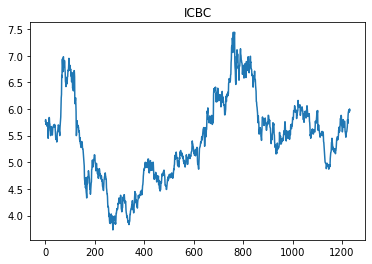

<Figure size 432x288 with 0 Axes>

In [4]:
G1 = ["BOC", "BOCHK", "BOCOM", "CCB", "HSB", "HSBC", "ICBC"]

df = pd.read_csv("Data/ICBC.csv")
    
plt.plot(df.Close)
plt.title("ICBC")
plt.show()
plt.clf()
    
data = df.Close.to_numpy().reshape(-1,1)

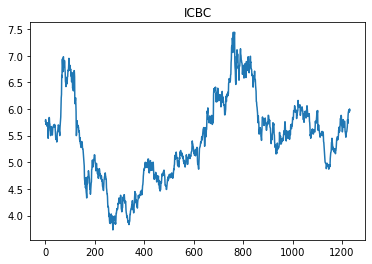

<Figure size 432x288 with 0 Axes>

In [5]:
df_tgt = pd.read_csv("Data/ICBC.csv")
    
plt.plot(df_tgt.Close)
plt.title("ICBC")
plt.show()
plt.clf()
    
target = df_tgt.Close.to_numpy().reshape(-1,1)

### Data preprocessing

In [6]:
def sliding_window(dataset, l, p, scaler, device):
    x, y = [], []

    for i in range(len(dataset)-l-p+1):
        #Get input of size l, starting from index i
        _x = dataset[i: i+l, :]
        _x = scaler.transform(_x)

        #Input needs to be transposed
        # _x = np.transpose(_x)

        #Get the next p values as label
        _y = dataset[i+l: i+l+p, 0].reshape(-1,1)
        _y = scaler.transform(_y)

        x.append(_x)
        y.append(_y)

    x = np.array(x)
    y = np.array(y)
    
    x = torch.tensor(x).to(dtype=torch.float32).to(device)
    y = torch.tensor(y).to(dtype=torch.float32).to(device)

    return (x, y)

In [7]:
def reverse_normalize(x, scaler):
    x = x.reshape(-1,1).to('cpu')
    x = scaler.inverse_transform(x)
    
    x = torch.tensor(x).to(dtype=torch.float32)
    return x

In [8]:
epochs = 100
l = 22
p = 1

In [9]:
#60-20-20 split
training_ind = int(len(data)*0.6)
validating_ind = int(len(data)*0.8)

training_set = data[:training_ind]
validation_set = data[training_ind:validating_ind]
test_set = data[validating_ind:]

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(training_set)

trainX, trainY = sliding_window(training_set, l, p, scaler, device)
valX, valY = sliding_window(validation_set, l, p, scaler, device)
testX, testY = sliding_window(test_set, l, p, scaler, device)

In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(target)
scaled_target = scaler.transform(target)

X, Y = sliding_window(target, l, p, scaler, device)

# Train models

In [11]:
class MLP(nn.Module):

    def __init__(self, l=22, p=1):
        super(MLP, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.Linear(l, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 16)
        
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(-1, self.l)
        
        x = self.l1(x)
        x = F.relu(x)
        
        x = self.l2(x)
        x = F.relu(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x)

        return x.reshape(batch_size, -1, self.p)

In [12]:
class LSTM(nn.Module):

    def __init__(self, l=22, p=1):
        super(LSTM, self).__init__()
        
        self.l = l
        self.p = p

        self.l1 = nn.LSTM(l, 128, batch_first=True)
        self.l2 = nn.LSTM(128, 64, batch_first=True)
        self.l3 = nn.Linear(64, 16)
        self.output = nn.Linear(16, p)
        

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape(batch_size, -1, self.l)
        
        x, _ = self.l1(x)
        x, _ = self.l2(x)
        
        x = self.l3(x)
        x = F.relu(x)
        
        x = self.output(x[:,-1,:])

        return x.reshape(batch_size, -1, self.p)

In [13]:
# Loss and indicator functions
def MAPE(x, y):
    return torch.mean(torch.abs((y - x) / y)) 

def RMSE(x, y):
    criterion = nn.MSELoss()
    return torch.sqrt(criterion(x, y))

def R2(x, y):
    target_mean = torch.mean(y)
    ss_tot = torch.sum((y - target_mean) ** 2)
    ss_res = torch.sum((y - x) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2

def indicator(x, y, scaler):
    x = reverse_normalize(x, scaler)
    y = reverse_normalize(y, scaler)
    
    mape = MAPE(x, y).item()
    rmse = RMSE(x, y).item()
    r2 = R2(x, y).item()
    
    return mape, rmse, r2

In [14]:
def build_model(MODEL, saved_path, freeze):
    net = MODEL(l, p)

    if torch.cuda.is_available():
        net.cuda()
        
    net.load_state_dict(torch.load(saved_path))
    
    count = 0
    for param in net.parameters():
        param.requires_grad = False
        
        count += 1
        if count == freeze:
            break

    optimizer = torch.optim.Adam(net.parameters(), lr=0.005)

    print(net)
    
    return net, optimizer

In [15]:
def train_model(net, optimizer, criterion, epochs, trainX, trainY, valX, valY, scaler):
    mse_train = np.zeros(epochs)
    mse_val = np.zeros(epochs)

    mape_train = np.zeros(epochs)
    mape_val = np.zeros(epochs)

    rmse_train = np.zeros(epochs)
    rmse_val = np.zeros(epochs)

    r2_train = np.zeros(epochs)
    r2_val = np.zeros(epochs)

    for epoch in range(epochs):    
        optimizer.zero_grad()

        pred = net(trainX)

        loss = criterion(pred, trainY)

        loss.backward()
        optimizer.step()

        if epoch == 0 or (epoch+1) % 100 == 0:
            print(f'epoch: {epoch+1:3}')
            print(f'loss: {loss.item():10.8f}')

        mse_train[epoch] = loss.item()

        results = indicator(pred.detach(), trainY, scaler)
        mape_train[epoch] = results[0]
        rmse_train[epoch] = results[1]
        r2_train[epoch] = results[2]


        with torch.no_grad():
            val_pred = net(valX)

            error = criterion(val_pred, valY)

            if epoch == 0 or (epoch+1) % 100 == 0:
                print(f'validation loss: {error.item():10.8f}')

            mse_val[epoch] = error.item()

            results = indicator(val_pred.detach(), valY, scaler)
            mape_val[epoch] = results[0]
            rmse_val[epoch] = results[1]
            r2_val[epoch] = results[2]
            
    return mse_train, mse_val, mape_train, mape_val, rmse_train, rmse_val, r2_train, r2_val

In [16]:
def visualize_result(train, val, name):
    epoch = range(1, len(train)+1)

    plt.plot(epoch, train, label='Training')
    plt.plot(epoch, val, label='Validating')

    plt.title(name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.clf()

In [17]:
def test_model(net, criterion, testX, testY, scaler):
    net.eval()
    pred = net(testX)
    
    loss = criterion(pred, testY).item()
    print(f'MSE: {loss:10.8f}')
    
    results = indicator(pred.detach(), testY, scaler)
    
    print(f'MAPE: {results[0]:10.8f}')
    print(f'RMSE: {results[1]:10.8f}')
    print(f'R2: {results[2]:10.8f}')

    label = reverse_normalize(testY, scaler).numpy().flatten()
    pred = reverse_normalize(pred.detach(), scaler).numpy().flatten()

    plt.plot(range(len(label)), label, label='Ground truth')
    plt.plot(range(len(label)), pred, label='Prediction')

    plt.title('Test')
    plt.xlabel('Session')
    plt.ylabel('Close')
    plt.legend()

    plt.show()
    
    return [loss] + list(results)

In [18]:
criterion = nn.MSELoss()

In [19]:
def build_and_train(MODEL, saved_path, freeze, trainX, trainY, valX, valY, testX, testY, scaler, criterion, X, Y, epochs):
    net, optimizer = build_model(MODEL, saved_path, freeze)
    
    mse_train, mse_val, mape_train, mape_val, rmse_train, rmse_val, r2_train, r2_val = train_model(net, optimizer, criterion, epochs, trainX, trainY, valX, valY, scaler)
    
    visualize_result(mse_train, mse_val, "MSE")
    visualize_result(mape_train, mape_val, "MAPE")
    visualize_result(rmse_train, rmse_val, "RMSE")
    visualize_result(r2_train, r2_val, "R2")

    test_results = test_model(net, criterion, testX, testY, scaler)
    target_results = test_model(net, criterion, X, Y, scaler)
    
    return net, target_results

In [20]:
mlp_results = {}
lstm_results = {}

BOC
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00246440
validation loss: 0.00587764
epoch: 100
loss: 0.00225930
validation loss: 0.00413110


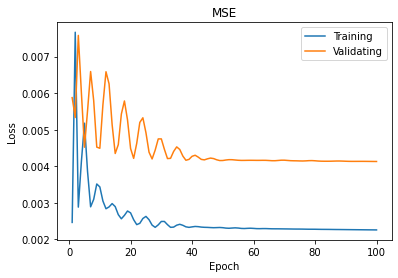

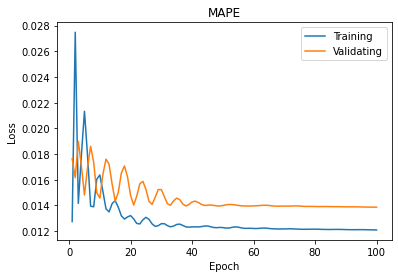

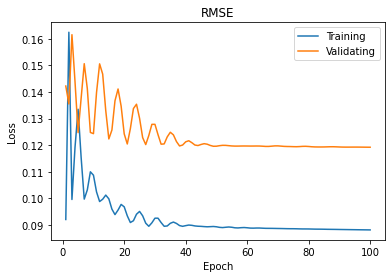

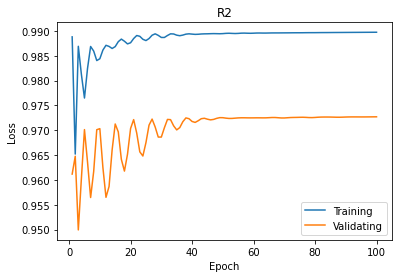

MSE: 0.00259987
MAPE: 0.01215968
RMSE: 0.09458448
R2: 0.93490636


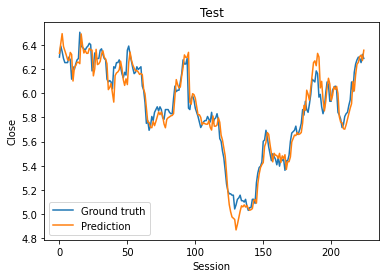

MSE: 0.00228353
MAPE: 0.01186791
RMSE: 0.08864359
R2: 0.98732847


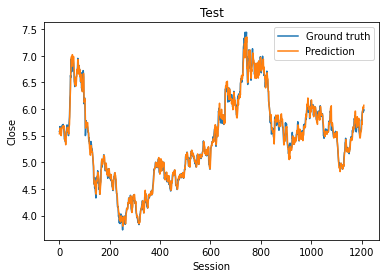

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00269689
validation loss: 0.03125875
epoch: 100
loss: 0.00229974
validation loss: 0.00457940


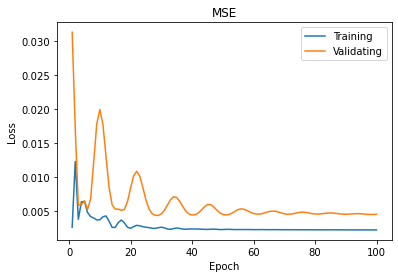

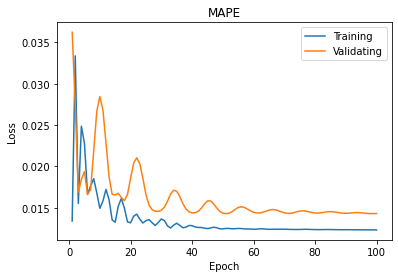

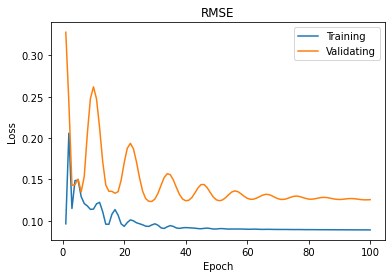

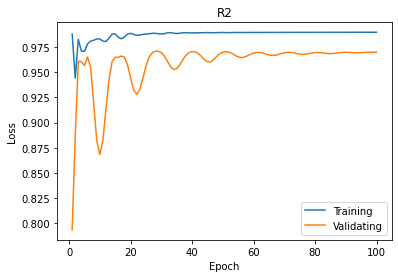

MSE: 0.00187688
MAPE: 0.01016432
RMSE: 0.08036408
R2: 0.95300817


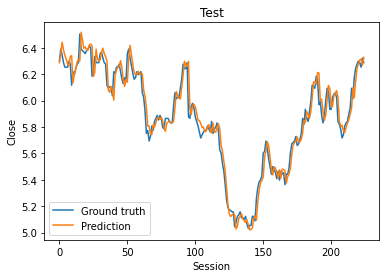

MSE: 0.00200881
MAPE: 0.01110221
RMSE: 0.08314072
R2: 0.98885292


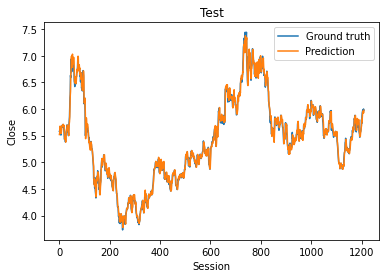

Models tuned.
BOCHK
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00345319
validation loss: 0.01487938
epoch: 100
loss: 0.00271322
validation loss: 0.00455483


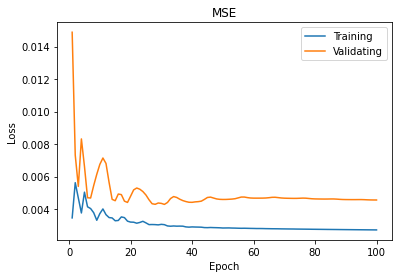

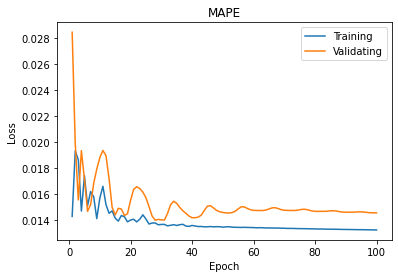

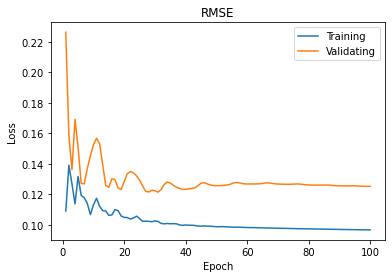

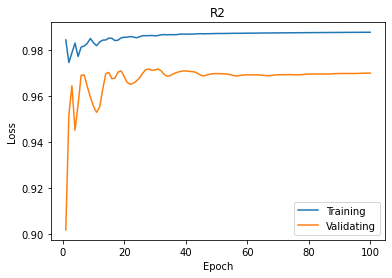

MSE: 0.00197604
MAPE: 0.01012962
RMSE: 0.08245977
R2: 0.95052534


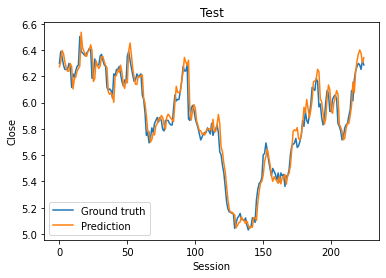

MSE: 0.00249383
MAPE: 0.01257525
RMSE: 0.09263551
R2: 0.98616153


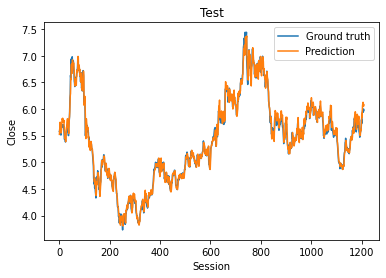

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00287075
validation loss: 0.01423040
epoch: 100
loss: 0.00246249
validation loss: 0.00412258


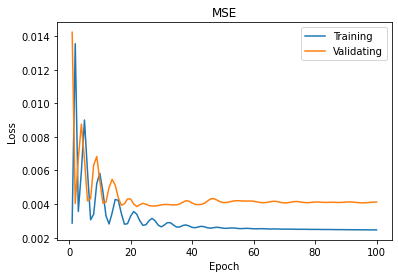

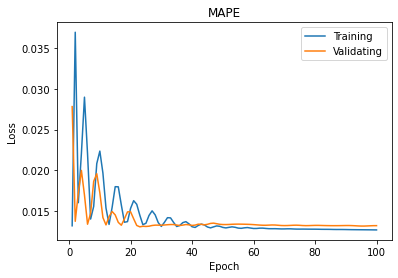

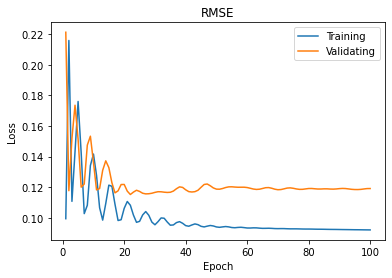

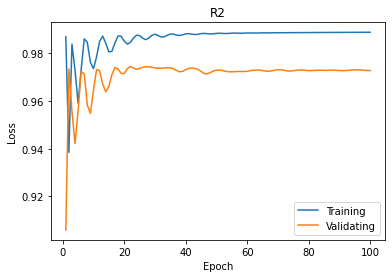

MSE: 0.00174337
MAPE: 0.00968803
RMSE: 0.07745307
R2: 0.95635086


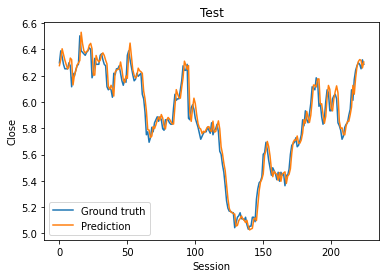

MSE: 0.00207111
MAPE: 0.01128687
RMSE: 0.08441997
R2: 0.98850721


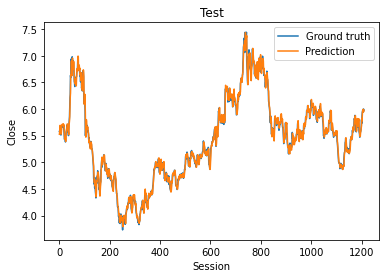

Models tuned.
BOCOM
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00308130
validation loss: 0.02538093
epoch: 100
loss: 0.00267988
validation loss: 0.00420030


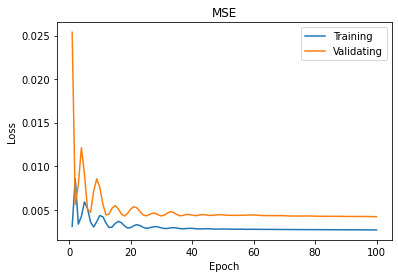

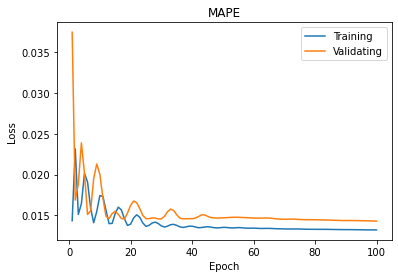

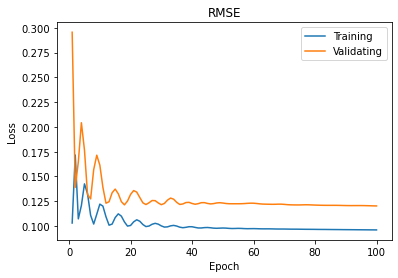

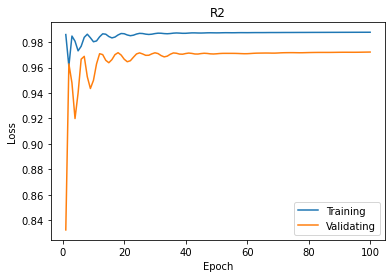

MSE: 0.00200672
MAPE: 0.01041018
RMSE: 0.08309732
R2: 0.94975734


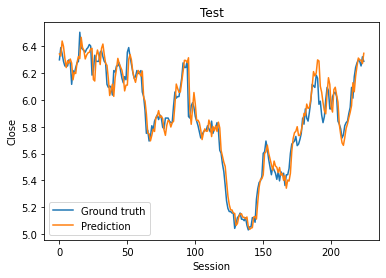

MSE: 0.00250675
MAPE: 0.01264552
RMSE: 0.09287515
R2: 0.98608983


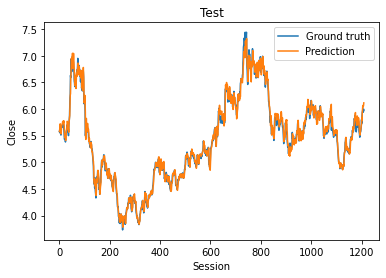

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00273059
validation loss: 0.02095487
epoch: 100
loss: 0.00244932
validation loss: 0.00417413


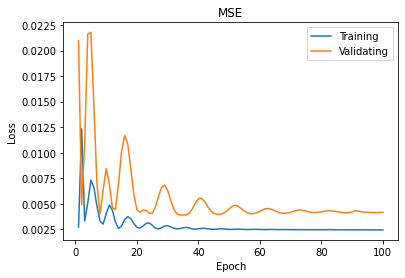

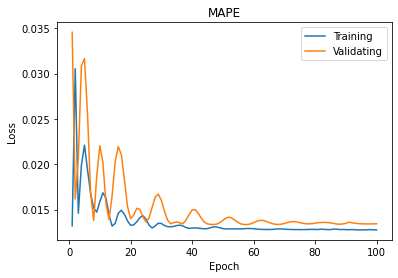

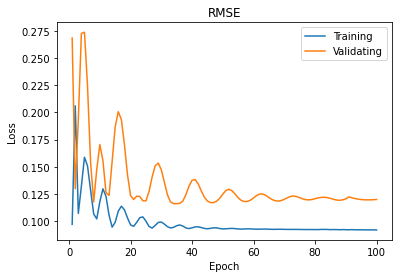

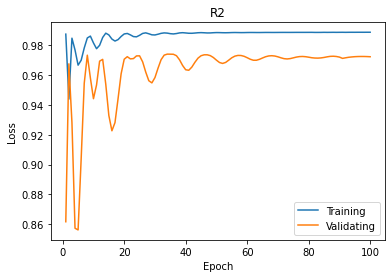

MSE: 0.00175062
MAPE: 0.00957717
RMSE: 0.07761404
R2: 0.95616925


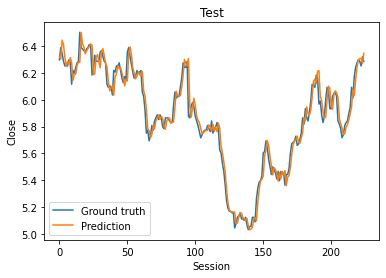

MSE: 0.00205557
MAPE: 0.01123838
RMSE: 0.08410273
R2: 0.98859346


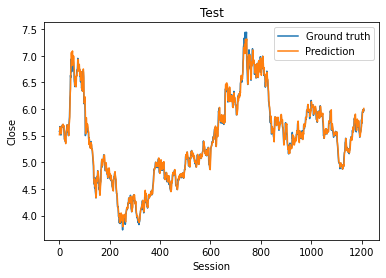

Models tuned.
CCB
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00219985
validation loss: 0.01148851
epoch: 100
loss: 0.00206438
validation loss: 0.00418732


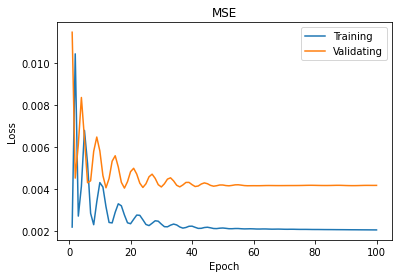

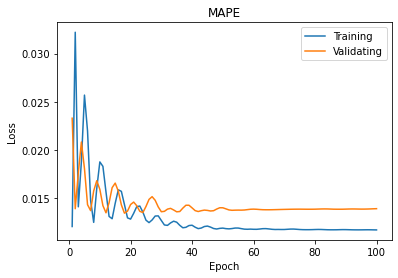

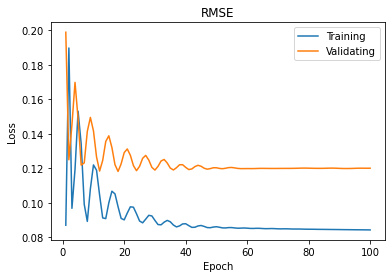

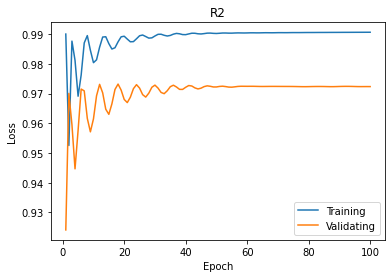

MSE: 0.00172180
MAPE: 0.00974271
RMSE: 0.07697245
R2: 0.95689088


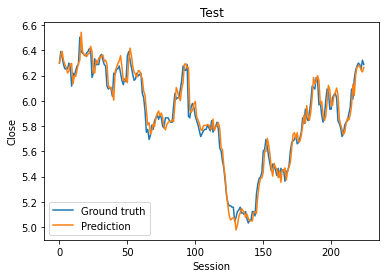

MSE: 0.00215821
MAPE: 0.01154865
RMSE: 0.08617696
R2: 0.98802388


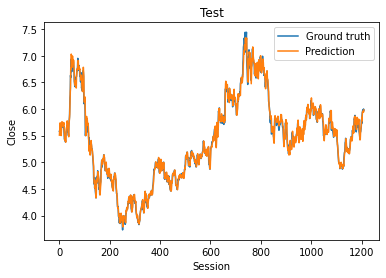

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00237877
validation loss: 0.01426813
epoch: 100
loss: 0.00228602
validation loss: 0.00413241


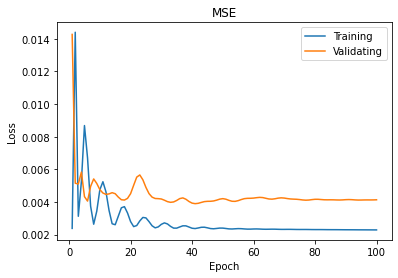

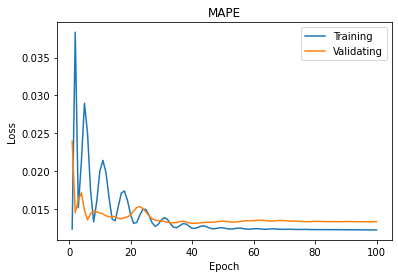

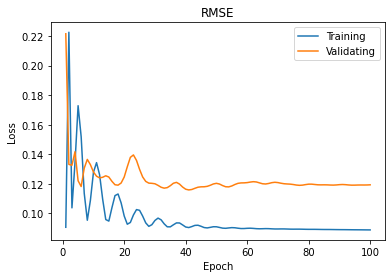

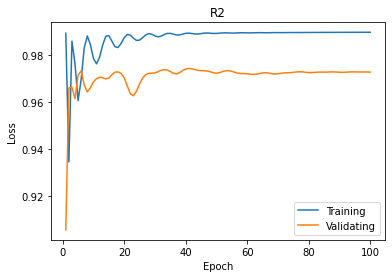

MSE: 0.00170769
MAPE: 0.00965294
RMSE: 0.07665639
R2: 0.95724416


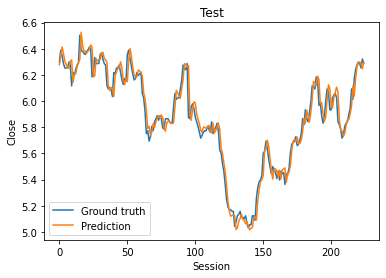

MSE: 0.00199243
MAPE: 0.01102591
RMSE: 0.08280106
R2: 0.98894382


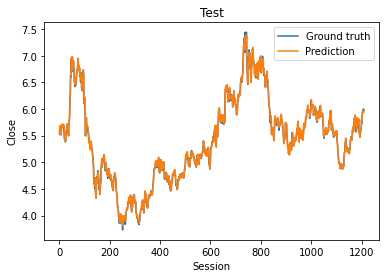

Models tuned.
HSB
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00299936
validation loss: 0.01402394
epoch: 100
loss: 0.00267267
validation loss: 0.00423843


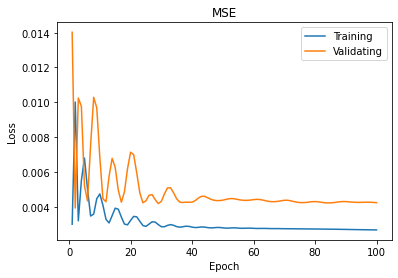

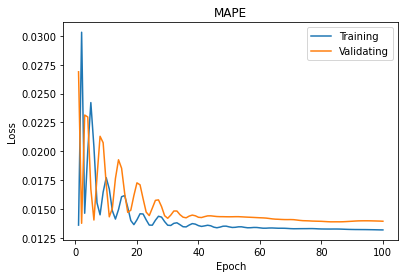

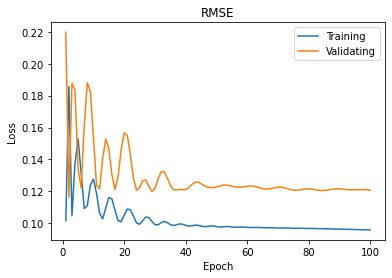

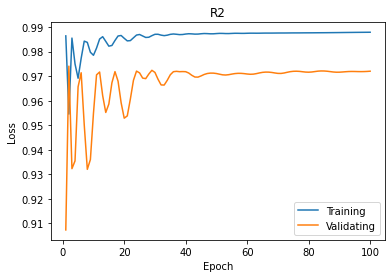

MSE: 0.00226920
MAPE: 0.01159365
RMSE: 0.08836503
R2: 0.94318545


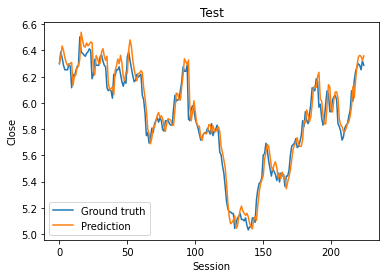

MSE: 0.00225053
MAPE: 0.01183135
RMSE: 0.08800082
R2: 0.98751158


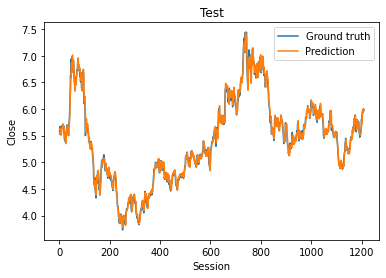

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00308556
validation loss: 0.01737909
epoch: 100
loss: 0.00250418
validation loss: 0.00460316


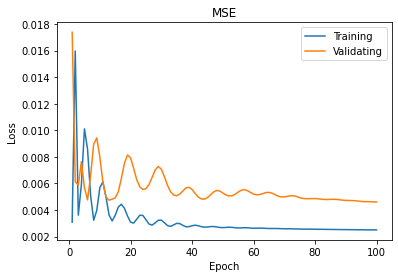

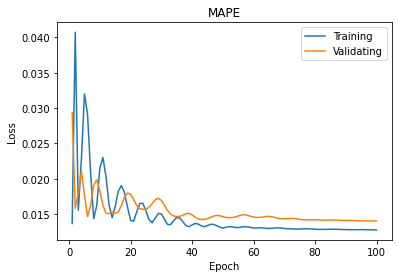

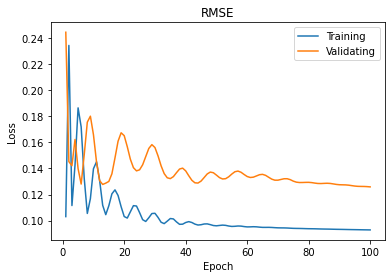

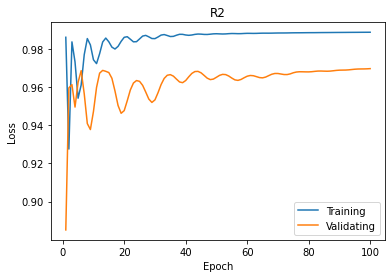

MSE: 0.00179826
MAPE: 0.00984567
RMSE: 0.07866294
R2: 0.95497656


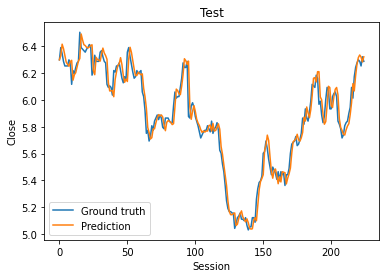

MSE: 0.00209511
MAPE: 0.01138325
RMSE: 0.08490774
R2: 0.98837405


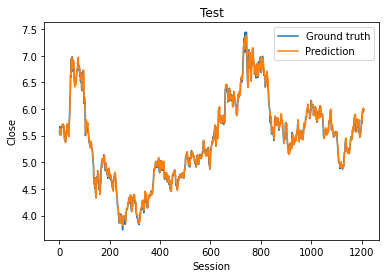

Models tuned.
HSBC
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00347937
validation loss: 0.00987371
epoch: 100
loss: 0.00270128
validation loss: 0.00379866


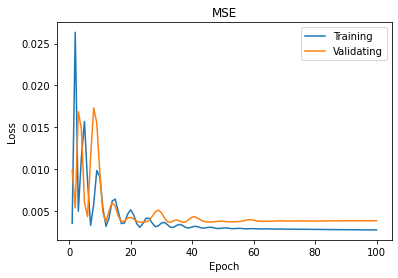

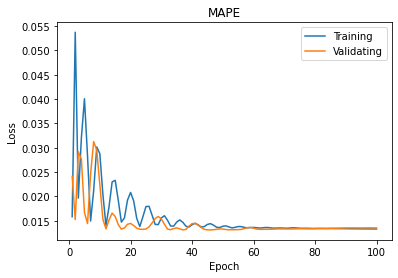

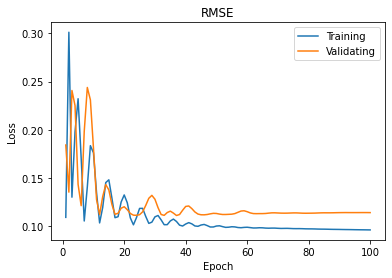

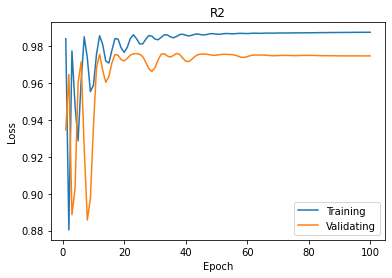

MSE: 0.00192639
MAPE: 0.00987899
RMSE: 0.08141718
R2: 0.95176852


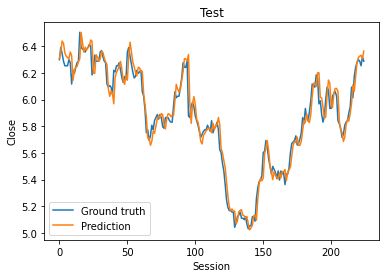

MSE: 0.00221237
MAPE: 0.01171108
RMSE: 0.08725138
R2: 0.98772341


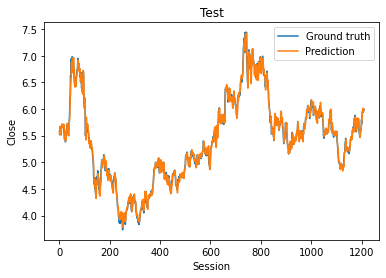

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00257840
validation loss: 0.00695461
epoch: 100
loss: 0.00236936
validation loss: 0.00369240


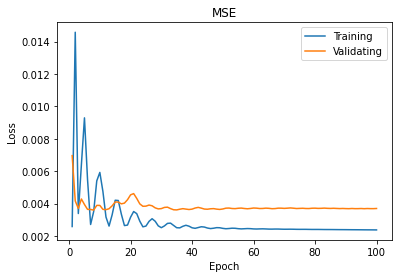

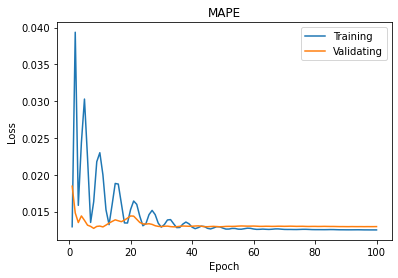

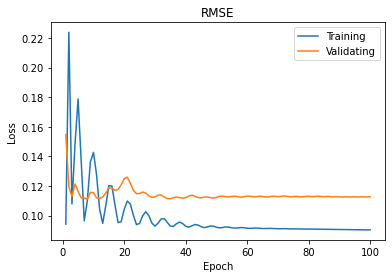

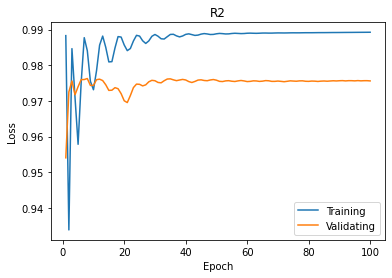

MSE: 0.00179066
MAPE: 0.00964384
RMSE: 0.07849646
R2: 0.95516694


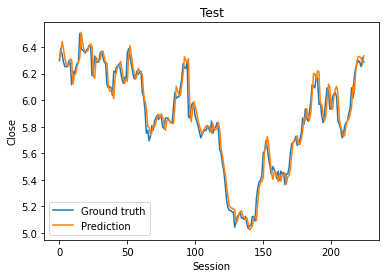

MSE: 0.00204340
MAPE: 0.01120655
RMSE: 0.08385342
R2: 0.98866099


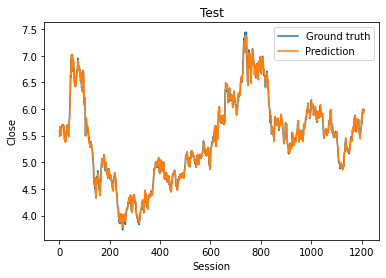

Models tuned.
ICBC
MLP(
  (l1): Linear(in_features=22, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=64, bias=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00181340
validation loss: 0.00573847
epoch: 100
loss: 0.00171546
validation loss: 0.00528498


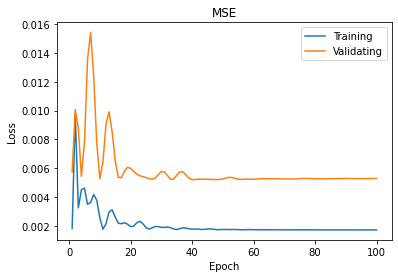

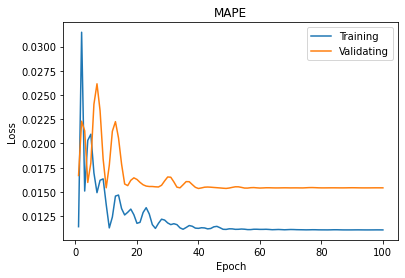

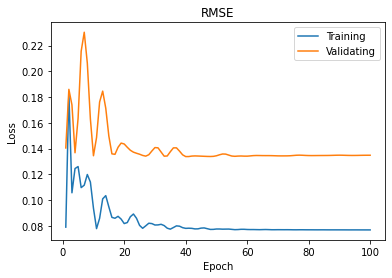

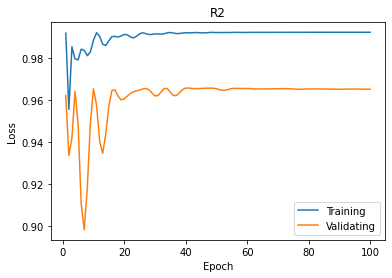

MSE: 0.00209958
MAPE: 0.01076737
RMSE: 0.08499835
R2: 0.94743222


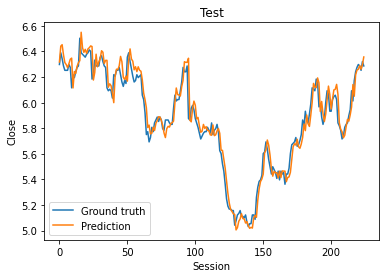

MSE: 0.00217750
MAPE: 0.01146270
RMSE: 0.08656121
R2: 0.98791683


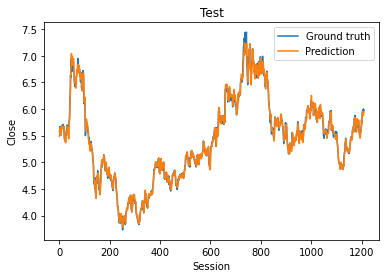

LSTM(
  (l1): LSTM(22, 128, batch_first=True)
  (l2): LSTM(128, 64, batch_first=True)
  (l3): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)
epoch:   1
loss: 0.00216669
validation loss: 0.01956603
epoch: 100
loss: 0.00214354
validation loss: 0.00421195


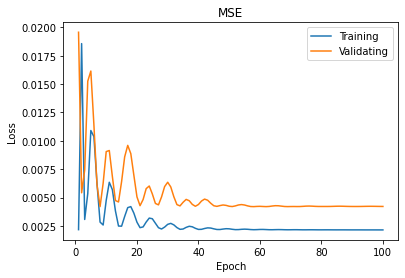

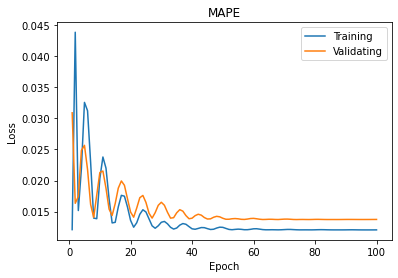

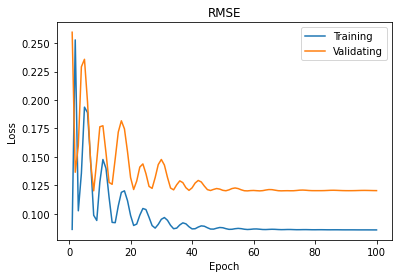

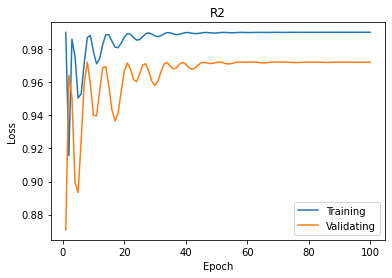

MSE: 0.00193426
MAPE: 0.01012575
RMSE: 0.08158339
R2: 0.95157140


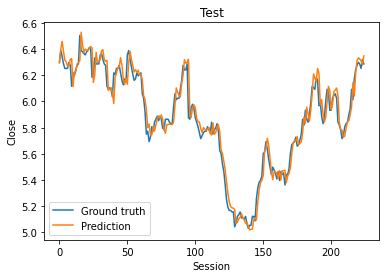

MSE: 0.00203176
MAPE: 0.01110470
RMSE: 0.08361419
R2: 0.98872560


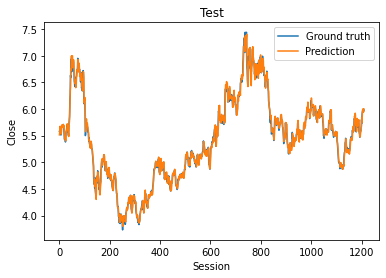

Models tuned.


In [21]:
# For each datasets, load the pretrained models, finetune using target dataset and save them
for corp in G1:
    print(corp)
    
    net1, results1 = build_and_train(MLP, "Models/" +  corp + "_MLP.pth", 3, trainX, trainY, valX, valY, testX, testY, scaler, criterion, X, Y, epochs)
    torch.save(net1.state_dict(), "Models/" +  corp + "_MLP_tuned.pth")
    mlp_results[corp] = results1
    
    net2, results2 = build_and_train(LSTM, "Models/" +  corp + "_LSTM.pth", 3, trainX, trainY, valX, valY, testX, testY, scaler, criterion, X, Y, epochs)
    torch.save(net2.state_dict(), "Models/" +  corp + "_LSTM_tuned.pth")
    lstm_results[corp] = results2
    
    print("Models tuned.")

Save results

In [22]:
mlp_pretrained = pd.DataFrame.from_dict(mlp_results, orient='index', columns=['MSE', 'MAPE', 'RMSE', 'R2'])
mlp_pretrained.to_csv("Results/mlp_tuned.csv")

mlp_pretrained

,MSE,MAPE,RMSE,R2
BOC,0.002284,0.011868,0.088644,0.987328
BOCHK,0.002494,0.012575,0.092636,0.986162
BOCOM,0.002507,0.012646,0.092875,0.986090
CCB,0.002158,0.011549,0.086177,0.988024
HSB,0.002251,0.011831,0.088001,0.987512
HSBC,0.002212,0.011711,0.087251,0.987723
ICBC,0.002178,0.011463,0.086561,0.987917


In [23]:
lstm_pretrained = pd.DataFrame.from_dict(lstm_results, orient='index', columns=['MSE', 'MAPE', 'RMSE', 'R2'])
lstm_pretrained.to_csv("Results/lstm_tuned.csv")

lstm_pretrained

,MSE,MAPE,RMSE,R2
BOC,0.002009,0.011102,0.083141,0.988853
BOCHK,0.002071,0.011287,0.084420,0.988507
BOCOM,0.002056,0.011238,0.084103,0.988593
CCB,0.001992,0.011026,0.082801,0.988944
HSB,0.002095,0.011383,0.084908,0.988374
HSBC,0.002043,0.011207,0.083853,0.988661
ICBC,0.002032,0.011105,0.083614,0.988726
